<a href="https://colab.research.google.com/github/adityapwr/speech-processing/blob/main/musicdemixing_speechprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install nussl

Spatial clustering

```
Kim, Minje, et al. “Gaussian mixture model for singing voice separation from stereophonic music.” Audio Engineering Society Conference: 43rd International Conference: Audio for Wirelessly Networked Personal Devices. Audio Engineering Society, 2011.
```

In [ ]:
import nussl
import matplotlib.pyplot as plt
import time
import numpy as np
import warnings
import json

warnings.filterwarnings("ignore")

nussl.utils.seed(0)


    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


In [ ]:
def visualize_waveform(audio_signal, ch=0, do_mono=False, x_axis='time', **kwargs):
    """
    Wrapper around `librosa.display.waveshow` for usage with AudioSignals.
    
    Args:
        audio_signal (AudioSignal): AudioSignal to plot
        ch (int, optional): Which channel to plot. Defaults to 0.
        do_mono (bool, optional): Make the AudioSignal mono. Defaults to False.
        x_axis (str, optional): x_axis argument to librosa.display.waveplot. Defaults to 'time'.
        kwargs: Additional keyword arguments to librosa.display.waveplot.
    """
    import librosa.display
    import matplotlib.pyplot as plt

    if do_mono:
        audio_signal = audio_signal.to_mono(overwrite=False)
    
    data = np.asfortranarray(audio_signal.audio_data[ch])
    librosa.display.waveshow(data, sr=audio_signal.sample_rate, x_axis=x_axis, **kwargs)
    plt.ylabel('Amplitude')

In [ ]:
def visualize_sources_as_waveform(audio_signals, ch=0, do_mono=False, x_axis='time', 
                                  colors=None, alphas=None, show_legend=True, **kwargs):
    """
    Visualizes a dictionary or list of sources with overlapping waveforms with transparency.
    
    The labels of each source are either the key, if a dictionary, or the 
    path to the input audio file, if a list.
    
    Args:
        audio_signals (list or dict): List or dictionary of audio signal objects to be
          plotted.
        ch (int, optional): Which channel to plot. Defaults to 0.
        do_mono (bool, optional): Make each AudioSignal mono. Defaults to False.
        x_axis (str, optional): x_axis argument to librosa.display.waveplot. Defaults to 'time'.
        colors (list, optional): Sequence of colors to use for each signal. 
          Defaults to None, which uses the default matplotlib color cycle.
        alphas (list, optional): Sequence of alpha transparency to use for each signal. 
          Defaults to None.
        kwargs: Additional keyword arguments to librosa.display.waveplot.
    """
    import matplotlib.pyplot as plt

    if isinstance(audio_signals, list):
        audio_signals = {
            f'{i}:{a.path_to_input_file}': a 
            for i, a in enumerate(audio_signals)
        }

    sorted_keys = sorted(
        audio_signals.keys(),
        key=lambda k: audio_signals[k].rms().mean(),
        reverse=True
    )

    alphas = (
        np.linspace(0.25, .75, len(audio_signals)) 
        if alphas is None else alphas
    )
    colors = (
        plt.rcParams['axes.prop_cycle'].by_key()['color'] 
        if colors is None else colors
    )

    for i, key in enumerate(sorted_keys):
        val = audio_signals[key]
        color = colors[i % len(audio_signals)]
        visualize_waveform(val, ch=ch, do_mono=do_mono, x_axis=x_axis, 
                           alpha=alphas[i % len(audio_signals)],
                           label=key, color=color)

    if show_legend:
        plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2)

In [ ]:
def visualize_and_embed(sources):
    nussl.play_utils.multitrack(sources)
    plt.figure(figsize=(10, 6))
    plt.subplot(211)
    nussl.utils.visualize_sources_as_masks(sources,
        y_axis='mel', db_cutoff=-40, alpha_amount=2.0)
    plt.subplot(212)
    visualize_sources_as_waveform(
        sources, show_legend=False)
    plt.show()
    

In [ ]:
musdb = nussl.datasets.MUSDB18(download=True)

Done!


In [ ]:
i = 21

In [ ]:
start_time = time.time()
item = musdb[i]
sources = [
    item['sources']['other'],
    item['sources']['vocals'],
    item['sources']['bass']
]

a = nussl.mixing.pan_audio_signal(sources[0], -35)
a_delays = [np.random.randint(1, 20) for _ in range(a.num_channels)]
a = nussl.mixing.delay_audio_signal(a, a_delays)

b = nussl.mixing.pan_audio_signal(sources[1], 0)
b_delays = [np.random.randint(1, 20) for _ in range(b.num_channels)]
b = nussl.mixing.delay_audio_signal(b, b_delays)

c = nussl.mixing.pan_audio_signal(sources[2], 35)
c_delays = [np.random.randint(1, 20) for _ in range(c.num_channels)]
c = nussl.mixing.delay_audio_signal(c, c_delays)

mix = a + b + c


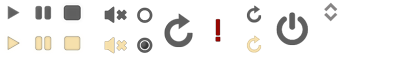
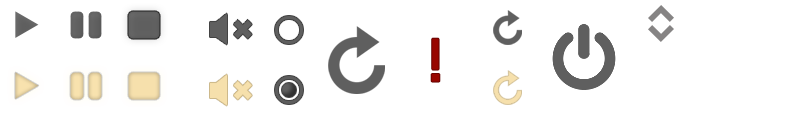
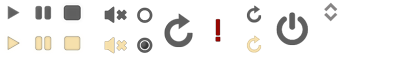

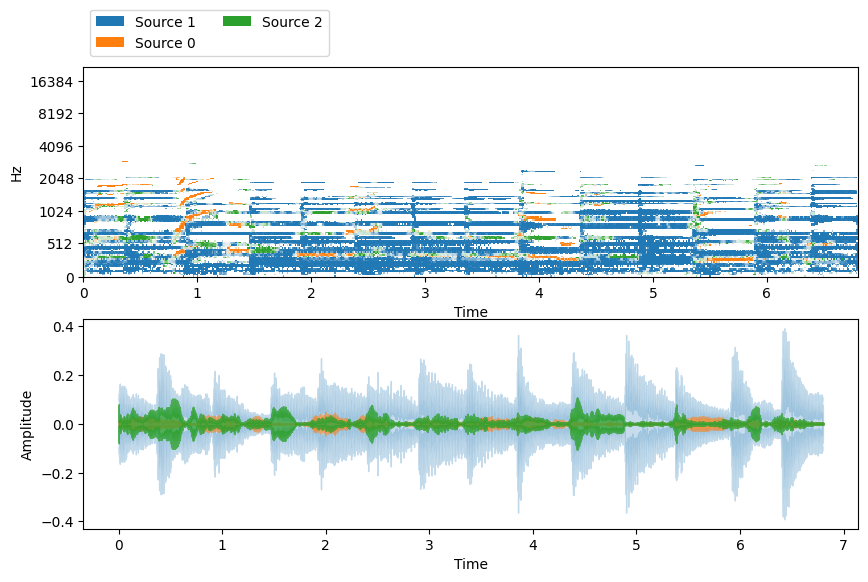

In [ ]:
separator = nussl.separation.spatial.SpatialClustering(
    mix, num_sources=3, mask_type='binary')
estimated_sources_list = separator()

estimates = {
    f'Source {i}': e for i, e in enumerate(estimated_sources_list)
}

visualize_and_embed(estimates)

In [ ]:
original_bss = nussl.evaluation.BSSEvalV4(
    sources, estimated_sources_list)
scores = original_bss.evaluate()

print(json.dumps(scores, indent=2))

{
  "combination": [
    0,
    1,
    2
  ],
  "permutation": [
    0,
    1,
    2
  ],
  "musdb/Clara Berry And Wooldog - Waltz For My Victims_other.wav": {
    "SDR": [
      -0.8600323516497332,
      -0.6195973926926645,
      -0.5068428076963701,
      -0.39317333173000296
    ],
    "ISR": [
      0.062489271106878345,
      0.034520265038004476,
      0.0030641142305128525,
      0.0014075979911788608
    ],
    "SIR": [
      -24.004142245733394,
      -22.081210215190218,
      -20.980937335258805,
      -20.62680602847407
    ],
    "SAR": [
      8.267299026727317,
      10.863290889302322,
      7.224069150151422,
      8.408611387459766
    ]
  },
  "musdb/Clara Berry And Wooldog - Waltz For My Victims_vocals.wav": {
    "SDR": [
      -1.7315655124968683,
      -2.400238133432185,
      -2.7215132433314055,
      -3.8228690144680213
    ],
    "ISR": [
      -0.02260327035080576,
      0.011652436402530301,
      -0.035156363939092425,
      0.06603940975308437
    ],
 

Independent Component Analysis

```
Independent component analysis: algorithms and applications
```

In [ ]:
start_time = time.time()
item = musdb[i]
sources = [item['sources']['other'], item['sources']['vocals']]

a = nussl.mixing.pan_audio_signal(sources[0], -35)
a_delays = [np.random.randint(1, 20) for _ in range(a.num_channels)]
a = nussl.mixing.delay_audio_signal(a, a_delays)

b = nussl.mixing.pan_audio_signal(sources[1], 35)
b_delays = [np.random.randint(1, 20) for _ in range(b.num_channels)]
b = nussl.mixing.delay_audio_signal(b, b_delays)

mix = a + b

audio_signals = [
    mix.make_audio_signal_from_channel(ch)
    for ch in range(mix.num_channels)
]


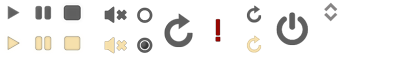
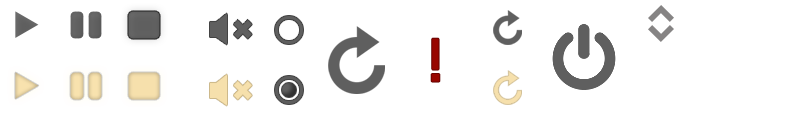
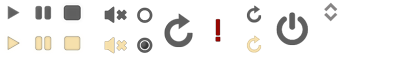

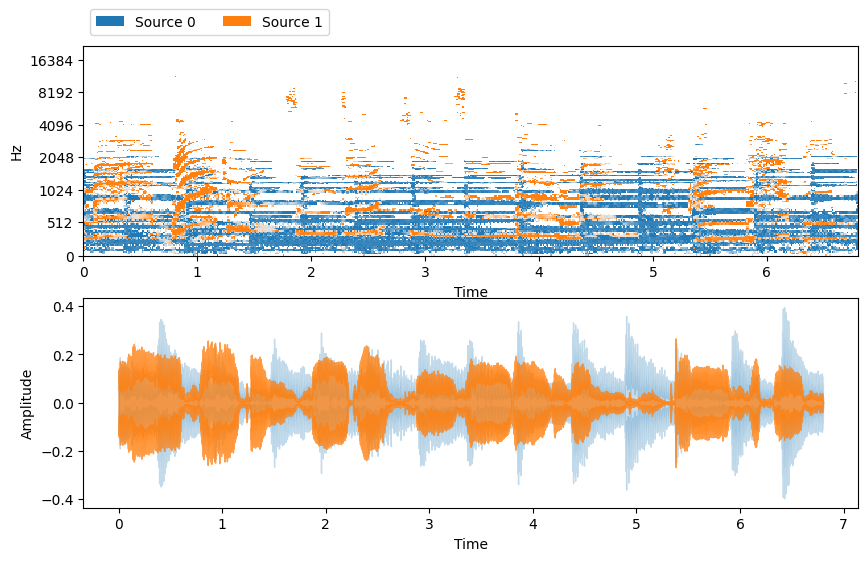

In [ ]:
separator = nussl.separation.factorization.ICA(audio_signals)
estimated_sources_list = separator()

estimates = {
    f'Source {i}': e for i, e in enumerate(estimated_sources_list)
}

visualize_and_embed(estimates)

In [ ]:
original_bss = nussl.evaluation.BSSEvalV4(
    audio_signals, estimated_sources_list)
scores = original_bss.evaluate()

print(json.dumps(scores, indent=2))

{
  "combination": [
    0,
    1
  ],
  "permutation": [
    0,
    1
  ],
  "musdb/Clara Berry And Wooldog - Waltz For My Victims_other.wav": {
    "SDR": [
      9.963383225232157,
      10.044018261812619,
      9.714868909817548,
      9.216440969971652
    ],
    "ISR": [
      12.433825626272558,
      12.467746782498752,
      13.290760500489448,
      12.616778046630168
    ],
    "SIR": [
      16.088107789377133,
      15.457614793514075,
      14.209196667612252,
      12.241291916525848
    ],
    "SAR": [
      68.64981851340367,
      67.63019082482478,
      67.00807287773483,
      65.12880991871171
    ]
  }
}
